In [ ]:
!pip install -q ultralytics torch torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_path = "/content/drive/My Drive/Data/person.zip"

# Directory to extract to
extract_dir = "/content"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted contents to {extract_dir}")

print(os.listdir("/content"))


Extracted contents to /content
['.config', 'my_archive.zip', 'person_detection.zip', 'person', 'person_detection', '.ipynb_checkpoints', 'runs', 'prediction.zip', 'dataset', 'yolo11n.pt', 'drive', 'val_predictions', 'val_predictions.zip', 'runs.zip', 'sample_data']


In [ ]:
#to split into train and val didnt do that already

import os
import shutil
import random

dataset_path = "/content/person"
images_path = os.path.join(dataset_path, "images")
labels_path = os.path.join(dataset_path, "labels")

# Create train and val directories
train_images = "/content/dataset/images/train"
val_images = "/content/dataset/images/val"
train_labels = "/content/dataset/labels/train"
val_labels = "/content/dataset/labels/val"

os.makedirs(train_images, exist_ok=True)
os.makedirs(val_images, exist_ok=True)
os.makedirs(train_labels, exist_ok=True)
os.makedirs(val_labels, exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Shuffle and split
random.seed(42)
random.shuffle(image_files)
split_ratio = 0.8
split_index = int(len(image_files) * split_ratio)

train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Move files
def move_files(file_list, source_folder, target_folder_images, target_folder_labels):
    for file in file_list:
        # Move image
        shutil.copy(os.path.join(source_folder, file), os.path.join(target_folder_images, file))
        # Move label (same name but .txt extension)
        label_file = file.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')
        label_path = os.path.join(labels_path, label_file)

        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(target_folder_labels, label_file))
        else:
            print(f"Warning: Label file missing for {file}. Skipping.")

move_files(train_files, images_path, train_images, train_labels)
move_files(val_files, images_path, val_images, val_labels)

print(f"Train images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")


Train images: 1416
Validation images: 355


In [ ]:
# Path to save dataset.yaml
yaml_path = "/content/dataset/dataset.yaml"

# Create YAML content
yaml_content = f"""
train: /content/dataset/images/train
val: /content/dataset/images/val

nc: 1
names: [ "person" ]
"""

# Write to file
with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

print(f"dataset.yaml created at {yaml_path}")


dataset.yaml created at /content/dataset/dataset.yaml


In [ ]:
from ultralytics import YOLO
import torch
import os
import shutil

def train_yolo_person_detector(
    data_yaml="dataset.yaml",
    model_size="n",
    epochs=50,
    imgsz=640,
    batch=16,
    workers=8,             # (adjust for system)
    project="person_detection",  # Project name
    name="yolo11_person",    # Experiment name
    device=None              # GPU/CPU selection
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Training on device: {device}")

    # Load YOLOv11 model with pretrained weights
    model = YOLO(f"yolo11{model_size}.pt")

    # Fine-tune the model with augmentations and single-class training
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        workers=workers,
        project=project,
        name=name,
        exist_ok=True,
        pretrained=True,  # Use pretrained weights
        amp=True,         # Automatic mixed precision
        device=device,
        save_period=5,    # Save weights every 5 epochs
        freeze=10,        # Freeze backbone layers
        mosaic=1.0,       # Enable mosaic augmentation
        mixup=0.1,        # Mixup augmentation
        fliplr=0.5,       # Horizontal flip probability
        translate=0.1,    # Translation augmentation
        scale=0.5,        # Scaling augmentation
        degrees=10.0,     # Rotation augmentation
        single_cls=True,  # Single-class training
        plots=True        # Save training/validation plots
    )

    # Save weights to Google Drive or local folder
    source_path = f"{project}/{name}/weights"
    target_path = "/content/drive/My Drive/person_detection_checkpoints"
    os.makedirs(target_path, exist_ok=True)

    for file in os.listdir(source_path):
        shutil.copy(os.path.join(source_path, file), target_path)

    print(f"Checkpoints saved to Google Drive at {target_path}")
    return results


if __name__ == "__main__":
    data_yaml_path = "/content/dataset/dataset.yaml"

    if not torch.cuda.is_available():
        print("Warning: GPU not available! Training will proceed on CPU.")
    else:
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")

    # Train the model
    results = train_yolo_person_detector(
        data_yaml=data_yaml_path,
        model_size="n",
        epochs=50,
        imgsz=640,
        batch=16,
        project="person_detection",
        name="yolo11_person_training",
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    # Print final results
    print("\nTraining Complete!")
    print(f"Final mAP50-95: {results.results_dict.get('metrics/mAP50-95', 0):.3f}")
    print(f"Final mAP50: {results.results_dict.get('metrics/mAP50', 0):.3f}")


Using GPU: Tesla T4
Training on device: cuda
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=cuda, workers=8, project=person_detection, name=yolo11_person_training, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

train: Scanning /content/dataset/labels/train.cache... 1393 images, 41 backgrounds, 0 corrupt: 100%|██████████| 1416/1416 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/dataset/labels/val.cache... 353 images, 4 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]


Plotting labels to person_detection/yolo11_person_training/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to person_detection/yolo11_person_training
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.67G      1.831      2.139      1.754         47        640: 100%|██████████| 89/89 [00:44<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


                   all        355        673      0.909      0.904      0.926      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.45G      1.564      1.461       1.51         29        640: 100%|██████████| 89/89 [00:44<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


                   all        355        673      0.862      0.906      0.907      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.48G      1.527      1.284      1.477         30        640: 100%|██████████| 89/89 [00:44<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


                   all        355        673      0.912      0.928      0.916      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.43G      1.498      1.143       1.45         22        640: 100%|██████████| 89/89 [00:42<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


                   all        355        673       0.92      0.953      0.932       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.47G      1.451      1.063      1.427         29        640: 100%|██████████| 89/89 [00:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]

                   all        355        673      0.911      0.929       0.93      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.43G      1.418       1.02      1.416         36        640: 100%|██████████| 89/89 [00:51<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

                   all        355        673      0.935      0.947      0.933      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.47G      1.397     0.9831      1.395         35        640: 100%|██████████| 89/89 [00:40<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


                   all        355        673      0.937      0.945      0.945      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.45G      1.339     0.9488      1.371         28        640: 100%|██████████| 89/89 [00:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]

                   all        355        673      0.925      0.945      0.947      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.47G      1.357     0.9294      1.369         24        640: 100%|██████████| 89/89 [00:44<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all        355        673      0.928      0.952      0.951      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.45G      1.346     0.9229      1.367         29        640: 100%|██████████| 89/89 [00:40<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

                   all        355        673      0.935      0.951      0.951      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.45G      1.286     0.8807      1.335         27        640: 100%|██████████| 89/89 [00:42<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]

                   all        355        673      0.923      0.964      0.954      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.45G      1.294     0.8822      1.338         33        640: 100%|██████████| 89/89 [00:42<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]

                   all        355        673       0.93       0.96      0.958      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.45G      1.282     0.8634      1.327         20        640: 100%|██████████| 89/89 [00:43<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

                   all        355        673      0.925      0.954      0.957      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.47G      1.243     0.8451      1.312         27        640: 100%|██████████| 89/89 [00:42<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]

                   all        355        673      0.931      0.958      0.953      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.46G      1.218     0.8337        1.3         30        640: 100%|██████████| 89/89 [00:42<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


                   all        355        673      0.923       0.96      0.958      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.45G      1.228     0.8376      1.298         26        640: 100%|██████████| 89/89 [00:49<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]

                   all        355        673      0.928      0.955      0.957      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.45G      1.206     0.8245      1.293         25        640: 100%|██████████| 89/89 [00:47<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]

                   all        355        673       0.92      0.957      0.962      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.45G      1.232     0.8413      1.314         38        640: 100%|██████████| 89/89 [00:42<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]


                   all        355        673       0.93      0.961      0.966      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.47G      1.213     0.8288       1.29         32        640: 100%|██████████| 89/89 [00:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]

                   all        355        673      0.924      0.953      0.963       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.45G      1.178     0.8103      1.277         26        640: 100%|██████████| 89/89 [00:41<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]

                   all        355        673      0.919      0.957      0.971      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.47G      1.168     0.7766      1.273         37        640: 100%|██████████| 89/89 [00:44<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]

                   all        355        673      0.933      0.963      0.965      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.45G      1.169     0.7958      1.269         31        640: 100%|██████████| 89/89 [00:41<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]

                   all        355        673      0.932      0.958      0.971      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.47G      1.179     0.7903      1.277         32        640: 100%|██████████| 89/89 [00:42<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

                   all        355        673      0.929      0.958      0.966       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.43G      1.149     0.7827      1.254         25        640: 100%|██████████| 89/89 [00:41<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]

                   all        355        673      0.938      0.959      0.973      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.43G      1.152     0.7812      1.264         36        640: 100%|██████████| 89/89 [00:41<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]

                   all        355        673       0.93      0.963       0.97      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.45G      1.133     0.7466      1.251         34        640: 100%|██████████| 89/89 [00:42<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]

                   all        355        673      0.918      0.964      0.966      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.43G      1.126     0.7557      1.248         40        640: 100%|██████████| 89/89 [00:42<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

                   all        355        673      0.929      0.965       0.97      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.47G      1.126     0.7559      1.249         24        640: 100%|██████████| 89/89 [00:45<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

                   all        355        673      0.926      0.963       0.97      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.45G      1.101     0.7515      1.236         30        640: 100%|██████████| 89/89 [00:40<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]

                   all        355        673      0.935       0.96       0.97      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.47G      1.104     0.7397      1.232         28        640: 100%|██████████| 89/89 [00:43<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]

                   all        355        673      0.929      0.966      0.972       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.43G       1.09     0.7366      1.225         21        640: 100%|██████████| 89/89 [00:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]

                   all        355        673      0.939      0.956      0.973      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.43G      1.071     0.7351      1.216         27        640: 100%|██████████| 89/89 [00:42<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]

                   all        355        673      0.932      0.958      0.974      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.45G      1.082     0.7308      1.223         32        640: 100%|██████████| 89/89 [00:45<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]

                   all        355        673      0.938      0.961      0.972      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.45G      1.082     0.7216      1.221         32        640: 100%|██████████| 89/89 [00:42<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]

                   all        355        673      0.937      0.961      0.974      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.45G      1.065     0.7061      1.214         27        640: 100%|██████████| 89/89 [00:43<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]

                   all        355        673      0.928      0.963      0.975      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.47G      1.053     0.7025      1.207         38        640: 100%|██████████| 89/89 [00:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]

                   all        355        673      0.942      0.961      0.977      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.45G      1.057     0.7088      1.206         26        640: 100%|██████████| 89/89 [00:42<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.40it/s]


                   all        355        673      0.936      0.964      0.974      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.45G      1.034     0.7019      1.195         32        640: 100%|██████████| 89/89 [00:44<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]

                   all        355        673      0.935      0.968      0.974      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.47G       1.03     0.6914       1.19         35        640: 100%|██████████| 89/89 [00:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

                   all        355        673      0.932       0.97      0.974      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.47G       1.03     0.6832      1.192         24        640: 100%|██████████| 89/89 [00:41<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]

                   all        355        673      0.938       0.97      0.978      0.715


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.43G     0.9369      0.503      1.151         14        640: 100%|██████████| 89/89 [00:43<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

                   all        355        673      0.938      0.968       0.98      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.43G       0.93     0.4833      1.146         16        640: 100%|██████████| 89/89 [00:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

                   all        355        673      0.928      0.967      0.974      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.43G      0.915     0.4664       1.15         12        640: 100%|██████████| 89/89 [00:39<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


                   all        355        673      0.936      0.966      0.973      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.43G     0.8947     0.4677      1.134         17        640: 100%|██████████| 89/89 [00:37<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]

                   all        355        673      0.927      0.958      0.973      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.43G     0.8833     0.4554      1.127         17        640: 100%|██████████| 89/89 [00:37<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]

                   all        355        673      0.929      0.966      0.976       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.43G     0.8655     0.4487      1.115         18        640: 100%|██████████| 89/89 [00:39<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


                   all        355        673      0.938       0.96      0.975      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.43G     0.8823     0.4552      1.128         14        640: 100%|██████████| 89/89 [00:39<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]

                   all        355        673      0.935      0.955      0.977      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.43G     0.8623     0.4486      1.117         16        640: 100%|██████████| 89/89 [00:39<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]

                   all        355        673      0.935       0.96      0.976      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.43G     0.8484     0.4413       1.11         15        640: 100%|██████████| 89/89 [00:41<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


                   all        355        673      0.938      0.963      0.976      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.43G     0.8352     0.4392      1.107         15        640: 100%|██████████| 89/89 [00:42<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.99it/s]


                   all        355        673      0.939      0.961      0.978      0.745

50 epochs completed in 0.703 hours.
Optimizer stripped from person_detection/yolo11_person_training/weights/last.pt, 5.5MB
Optimizer stripped from person_detection/yolo11_person_training/weights/best.pt, 5.5MB

Validating person_detection/yolo11_person_training/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


                   all        355        673      0.938       0.96      0.977      0.744
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to person_detection/yolo11_person_training
Checkpoints saved to Google Drive at /content/drive/My Drive/person_detection_checkpoints

Training Complete!
Final mAP50-95: 0.000
Final mAP50: 0.000



image 1/355 /content/dataset/images/val/100_top2.jpg: 544x640 1 person, 40.8ms
image 2/355 /content/dataset/images/val/103_top3.jpg: 544x640 2 persons, 24.0ms
image 3/355 /content/dataset/images/val/104_top2.jpg: 544x640 1 person, 25.3ms
image 4/355 /content/dataset/images/val/105_top1.jpg: 544x640 2 persons, 13.9ms
image 5/355 /content/dataset/images/val/109_top2.jpg: 544x640 1 person, 11.2ms
image 6/355 /content/dataset/images/val/116_top2.jpg: 544x640 2 persons, 15.3ms
image 7/355 /content/dataset/images/val/11_top1.jpg: 544x640 2 persons, 11.1ms
image 8/355 /content/dataset/images/val/121_top2.jpg: 544x640 2 persons, 13.0ms
image 9/355 /content/dataset/images/val/122_top1.jpg: 544x640 2 persons, 13.7ms
image 10/355 /content/dataset/images/val/124_top1.jpg: 544x640 2 persons, 11.1ms
image 11/355 /content/dataset/images/val/126_top3.jpg: 544x640 1 person, 10.9ms
image 12/355 /content/dataset/images/val/128_top1.jpg: 544x640 2 persons, 13.2ms
image 13/355 /content/dataset/images/val/

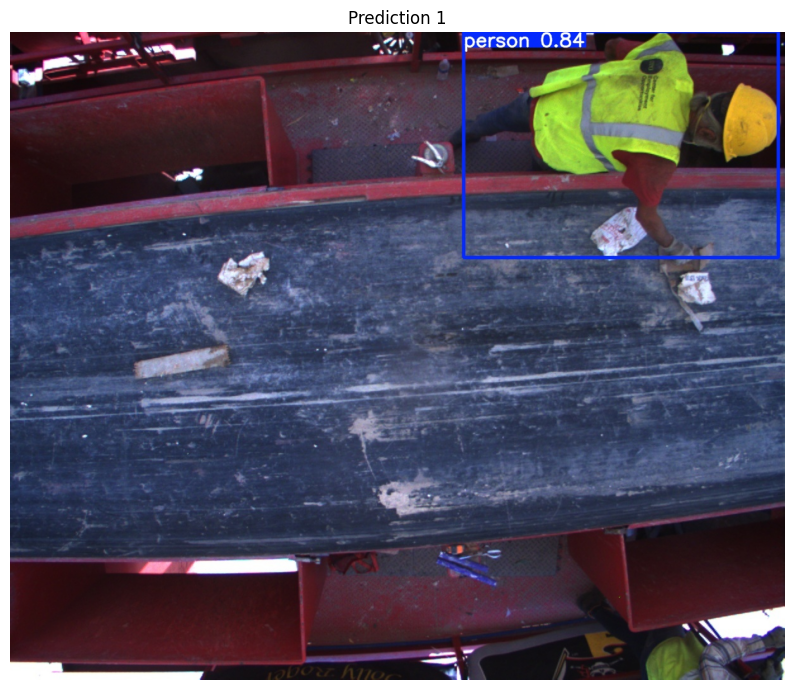

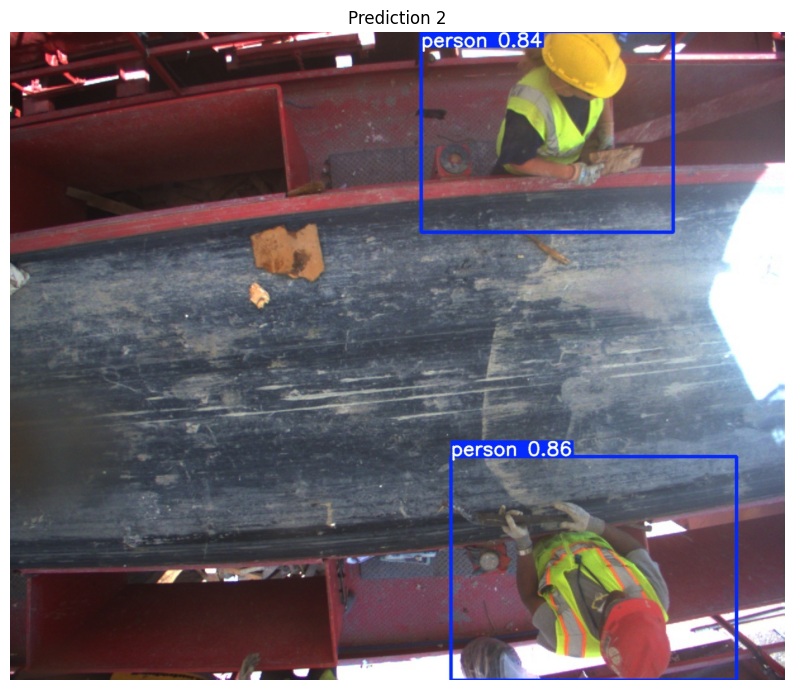

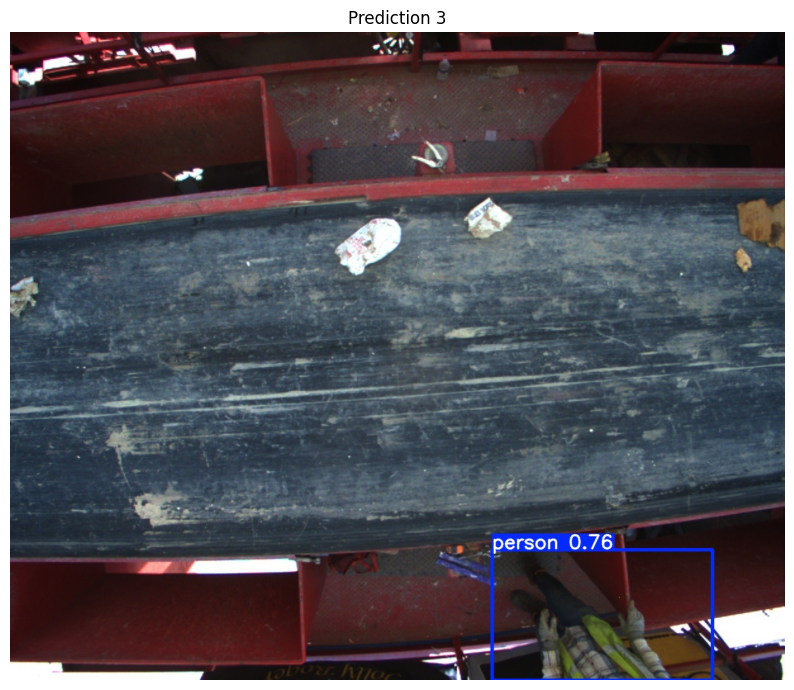

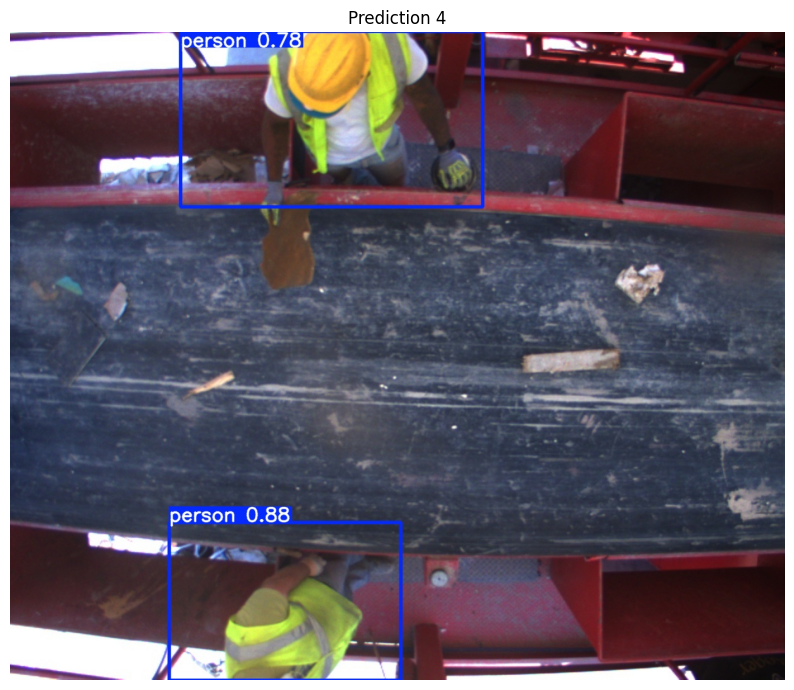

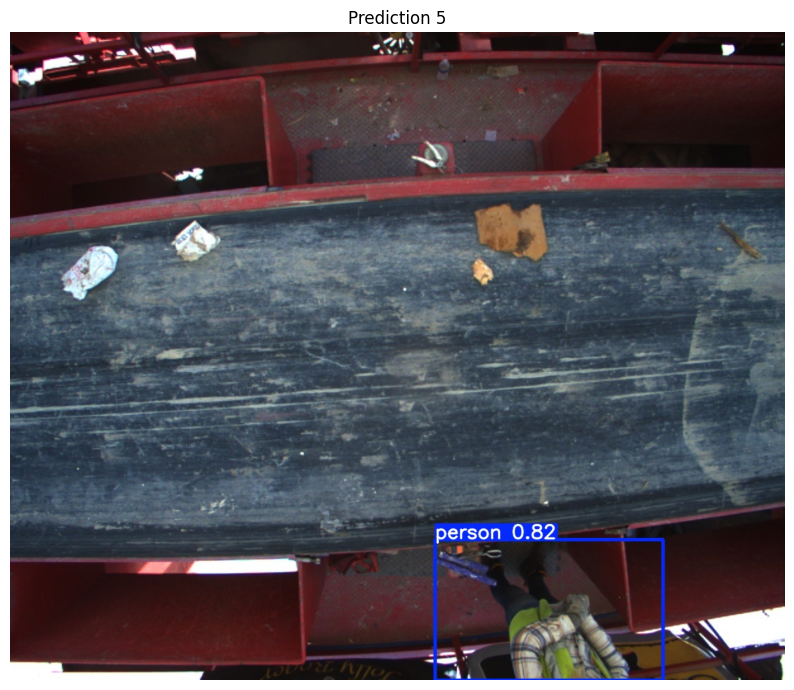

In [ ]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import cv2

def visualize_predictions(model_path, val_images_path, save_dir="val_predictions", imgsz=640):
    """
    Visualize predictions on validation images.

    Args:
        model_path (str): Path to the trained model weights (e.g., 'best.pt').
        val_images_path (str): Path to the validation images directory.
        save_dir (str): Directory to save prediction visualizations.
        imgsz (int): Image size for prediction.
    """
    # Load the trained YOLO model
    model = YOLO(model_path)

    # Predict on validation images
    results = model.predict(source=val_images_path, save=True, save_txt=False, imgsz=imgsz)

    # Get the save directory from the first result
    save_dir = results[0].save_dir if len(results) > 0 else None

    if save_dir is None:
        print("No predictions were made.")
        return

    print(f"Results saved to: {save_dir}")

    # Display a few results
    for idx, result in enumerate(results):
        if idx >= 5:  # Show only first 5 images
            break

        # Load the image with predictions
        img_path = os.path.join(save_dir, os.path.basename(result.path))
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not load image: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Prediction {idx+1}")
        plt.show()


if __name__ == "__main__":
    # Path to the trained model
    model_path = "person_detection/yolo11_person_training/weights/best.pt"  # Adjust based on your setup

    # Path to validation images
    val_images_path = "/content/dataset/images/val"  # Adjust based on your dataset structure

    # Visualize predictions
    visualize_predictions(model_path=model_path, val_images_path=val_images_path)


In [ ]:
import shutil
from google.colab import files

def compress_and_download(folder_path, output_name):
    # Compress the folder into a zip file
    zip_path = f"/content/{output_name}.zip"
    shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=folder_path)

# # Paths to the folders
# folder_1 = "/content/person_detection"
# folder_2 = "/content/val_predictions"

# # Output zip names
# output_1 = "person_detection"
# output_2 = "val_predictions"

# # Compress and download both folders
# compress_and_download(folder_1, output_1)
# compress_and_download(folder_2, output_2)

folder_3 = "/content/runs/detect/predict2"
output_3 = "prediction"
compress_and_download(folder_3, output_3)


In [ ]:
import shutil

shutil.make_archive("my_archive", "zip", "/content/runs")

'/content/my_archive.zip'